# Preprocessing data

In [129]:
# importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

## Visualization

In [130]:
# carregando base de dados de treinamento
EFPg_train = np.load("../../../Data/DataJetTagging/Trainning/g_jets_efps_d5_primed.npy")
EFPq_train = np.load("../../../Data/DataJetTagging/Trainning/q_jets_efps_d5_primed.npy")
EFPt_train = np.load("../../../Data/DataJetTagging/Trainning/t_jets_efps_d5_primed.npy")

In [131]:
dataset = EFPg_train # escolhendo o conjunto de dados que vamos visualizar
column_index = 40 # escolhendo o índice da coluna

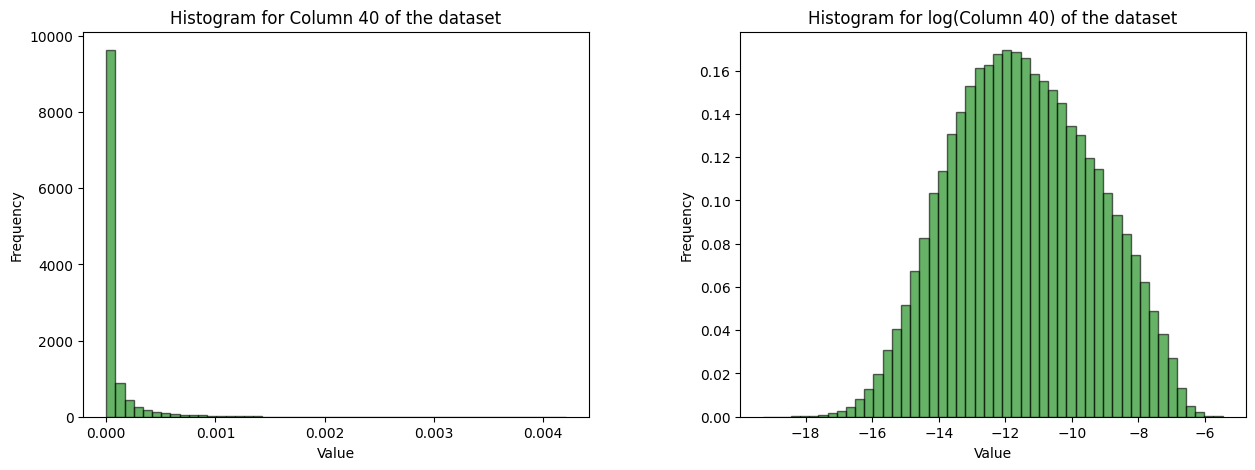

In [132]:
data = dataset[:, column_index] # valores da coluna
data_log = np.log(data) # logarithmic-scaling

nbins = 50 # número de bins no histograma

fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.3)

# histograma - sem normalizar
axes[0].hist(data, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Value")
axes[0].set_title(f'Histogram for Column {column_index} of the dataset')

# histograma - normalizando
axes[1].hist(data_log, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Value")
axes[1].set_title(f'Histogram for log(Column {column_index}) of the dataset')

plt.show()

## Normalizations

In [133]:
def norm(n,data):
    # n = 0, 1, 2, 3, 4, 5
    
    if n==0:
        return data
    elif n==1:
        return MinMaxScaler().fit_transform(data)
    elif n==2:
        return StandardScaler().fit_transform(data)
    elif n==3:
        return np.log(data)
    elif n==4:
        return MinMaxScaler().fit_transform(np.log(data))
    else: # n==5
        return StandardScaler().fit_transform(np.log(data))
    
# lembrando que não é possível aplicar MinMax/Standard e depois log, por isso não acrescentamos essas opções.

In [134]:
# escolhendo a normalização
n = 0

## Partitioning and Splitting

In [7]:
"""File that contains the routines to split the datasets for the Top-tagging and Quark-Gluon tagging using the EFPs."""

from ML.EFPs.data_loaders import load_data_top_tagging, load_data_qg_tagging


def split(tagging):
    """Splits the data according to the tagging."""
    
    if tagging == "top":
        X_train, y_train = load_data_top_tagging(
            top_data_path="../../../Data/DataJetTagging/Trainning/t_jets_efps_d5_primed.npy",
            quark_data_path="../../../Data/DataJetTagging/Trainning/q_jets_efps_d5_primed.npy",
            gluon_data_path="../../../Data/DataJetTagging/Trainning/g_jets_efps_d5_primed.npy"
        )
        X_val, y_val = load_data_top_tagging(
            top_data_path="../../../Data/DataJetTagging/Validation/t_jets_efps_d5_primed.npy",
            quark_data_path="../../../Data/DataJetTagging/Validation/q_jets_efps_d5_primed.npy",
            gluon_data_path="../../../Data/DataJetTagging/Validation/g_jets_efps_d5_primed.npy"
        )
        X_test, y_test = load_data_top_tagging(
            top_data_path="../../../Data/DataJetTagging/Test/t_jets_efps_d5_primed.npy",
            quark_data_path="../../../Data/DataJetTagging/Test/q_jets_efps_d5_primed.npy",
            gluon_data_path="../../../Data/DataJetTagging/Test/g_jets_efps_d5_primed.npy"
        )
    else:
        X_train, y_train = load_data_qg_tagging(
            quark_data_path="../../../Data/DataJetTagging/Trainning/q_jets_efps_d5_primed.npy",
            gluon_data_path="../../../Data/DataJetTagging/Trainning/g_jets_efps_d5_primed.npy"
        )
        X_val, y_val = load_data_qg_tagging(
            quark_data_path="../../../Data/DataJetTagging/Validation/q_jets_efps_d5_primed.npy",
            gluon_data_path="../../../Data/DataJetTagging/Validation/g_jets_efps_d5_primed.npy"
        )
        X_test, y_test = load_data_qg_tagging(
            quark_data_path="../../../Data/DataJetTagging/Test/q_jets_efps_d5_primed.npy",
            gluon_data_path="../../../Data/DataJetTagging/Test/g_jets_efps_d5_primed.npy"
        )

    return X_train, X_val, X_test, y_train, y_val, y_test

Writing split.py


In [2]:
# escolhendo se vamos fazer top tagging ou quark/gluon tagging
tagging = "qg"

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = split(tagging)

In [5]:
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Dimensionality reduction

Explicabilidade da primeira componente principal (PC1): 0.858
Explicabilidade da segunda componente principal (PC2): 0.997


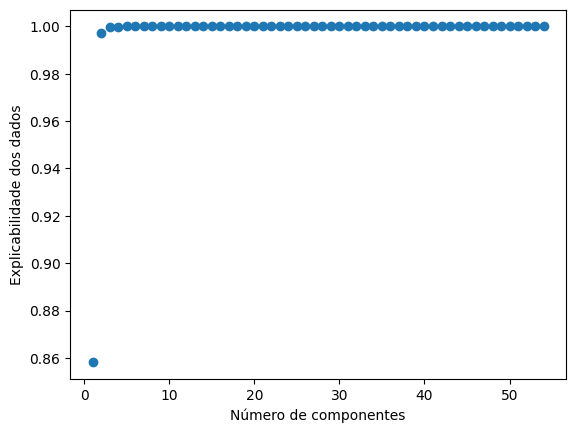

In [139]:
# conjuntos onde vamos aplicar o PCA:
X = np.concatenate((X_train, X_val, X_test), axis=0)

pca = PCA()
pca.fit(X)
explainability = pca.explained_variance_ratio_.cumsum()
factors = range(1,len(pca.explained_variance_ratio_)+1)
plt.scatter(factors,explainability)
# plt.hlines(0.9,0,20,'r')
plt.xlabel('Número de componentes')
plt.ylabel('Explicabilidade dos dados')
print('Explicabilidade da primeira componente principal (PC1):', explainability[0].round(3))
print('Explicabilidade da segunda componente principal (PC2):', explainability[1].round(3))

In [140]:
# coeficientes da PC1
pca.components_[0]

array([ 9.73206462e-01, -2.17595514e-01, -6.24310340e-02, -1.97026353e-02,
       -6.88006646e-03, -2.58285173e-03, -3.16755823e-02, -9.18028366e-03,
       -3.09785753e-03, -2.85094779e-03, -1.13958510e-03, -1.01203539e-03,
       -4.28372530e-03, -1.14974397e-03, -3.87143119e-04, -3.09882379e-04,
       -4.66124206e-03, -1.47058318e-03, -5.25946829e-04, -4.87214907e-04,
       -4.58537385e-03, -1.35948358e-03, -1.41260295e-03, -4.69645402e-04,
       -5.01077610e-04, -4.18986851e-04, -4.46211982e-04, -6.55919772e-04,
       -1.77091522e-04, -1.92809675e-04, -2.05446669e-04, -1.08381653e-03,
       -3.59305634e-04, -1.14832279e-04, -7.33250627e-04, -2.44563270e-04,
       -7.20967166e-04, -2.31381867e-04, -2.37539399e-04, -2.20087113e-04,
       -6.76821439e-04, -2.11038509e-04, -2.15824999e-04, -1.16828718e-04,
       -1.02627447e-04, -9.58640474e-05, -1.75950882e-04, -1.12581639e-04,
       -1.05656738e-04, -1.29831243e-04, -1.13444879e-04, -1.06490231e-04,
       -1.15099087e-04, -

In [141]:
# coeficientes da PC2
pca.components_[1]

array([2.29548924e-01, 9.02186004e-01, 2.97185112e-01, 1.00463348e-01,
       3.57824214e-02, 1.33558832e-02, 1.65818599e-01, 5.26569220e-02,
       1.83269572e-02, 1.72967438e-02, 6.74592039e-03, 6.22164266e-03,
       1.57629965e-02, 4.43413461e-03, 1.54581438e-03, 1.20960238e-03,
       3.32610151e-02, 1.10287925e-02, 3.97885156e-03, 3.79171973e-03,
       2.52054978e-02, 7.95601756e-03, 8.17383884e-03, 2.80306118e-03,
       2.93668024e-03, 2.56537425e-03, 2.67980741e-03, 2.91507911e-03,
       8.06023470e-04, 8.72661915e-04, 9.59030651e-04, 6.56801109e-03,
       2.25612540e-03, 4.90227889e-04, 7.59818067e-03, 2.62904167e-03,
       4.59200894e-03, 1.52739731e-03, 1.54664261e-03, 1.45666304e-03,
       4.25117951e-03, 1.38688113e-03, 1.40558524e-03, 6.32094883e-04,
       5.20785596e-04, 4.61339640e-04, 1.19579235e-03, 5.69385235e-04,
       1.91976442e-03, 9.79912429e-04, 7.78663401e-04, 7.15586792e-04,
       8.46125499e-04, 6.92089640e-04])

In [142]:
X_pca = pca.transform(X) # variáveis preditoras no espaço das PCs
N = 20 # número de PCs que vamos pegar
X_pca = X_pca[:,:N] # pegando as N primeiras PCs

In [143]:
# executar essa célula para rodar o modelo utilizando apenas as PCs
X_train, X_val, X_test = X_pca[:len(X_train)], X_pca[len(X_train):len(X_train)+len(X_val)], X_pca[len(X_train)+len(X_val):]

# Model

In [146]:
# escolhendo o modelo
model = LinearDiscriminantAnalysis() # LinearDiscriminantAnalysis() ou QuadraticDiscriminantAnalysis(tol=1.0e-6)
model.fit(X_train, y_train.ravel())

LinearDiscriminantAnalysis()

Intercept: -0.051176049713609006


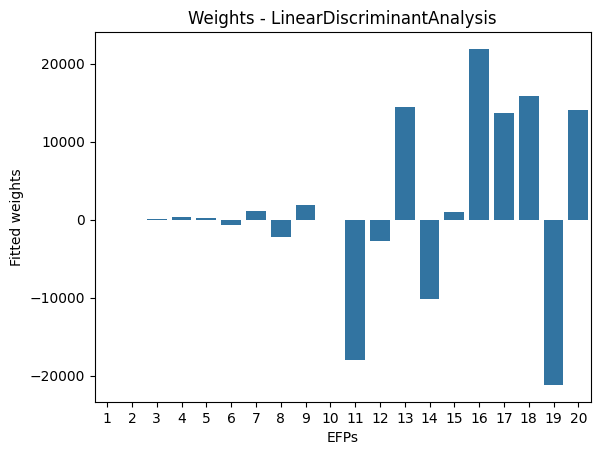

In [147]:
# NÃO EXECUTAR ESSA CÉLULA SE 0 MODELO NÃO POSSUIR intercept_ OU coef_

# intercept
print('Intercept:', model.intercept_[0])

# weights
coef = model.coef_[0]
sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Fitted weights")
plt.title("Weights - LinearDiscriminantAnalysis");

In [ ]:
coef

# Performance metrics

In [ ]:
def performance_metrics(set):
    # set == "train", "test"
    
    # escolhendo se vamos avaliar o conjunto de treinamento ou de teste
    if set == "train":
        X_set, y_set = X_train, y_train
    else: # set == "test"
        X_set, y_set = X_test, y_test
    
    y_pred = model.predict(X_set)
    # Classification Report
    print('Classification Report:\n',metrics.classification_report(y_set.ravel(), y_pred, digits=3))
    
    # Confusion Matrix
    print('Confusion Matrix:\n',metrics.confusion_matrix(y_set.ravel(), y_pred, normalize='all').round(2))
    
    y_predproba = model.predict_proba(X_set)[:, -1]
    # ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_set.ravel(), y_predproba)
    roc_auc = metrics.roc_auc_score(y_set.ravel(), y_predproba)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.plot([0,1],[0,1],'r--')
    plt.show()

In [ ]:
performance_metrics("train")